In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class Preprocessing():
    def __init__(self, k_size=6):
        self.k_size = k_size
        kmers = self.ref_kmers("", self.k_size)
        self.vectorizer = CountVectorizer(vocabulary = kmers)
        self.seqs = []

    def ref_kmers(self, current_kmer, current_depth):
        if current_depth == 1:
            return [current_kmer+"a",current_kmer+"u",current_kmer+"c",current_kmer+"g"]
        else:
            ret = self.ref_kmers(current_kmer+"a",current_depth-1)
            for nt in ['u','c','g']:
                ret += self.ref_kmers(current_kmer+nt,current_depth-1)
            return ret

    def seq2kmer(self, seq, k):
        kmer = ""
        for i in range(0,len(seq)-k,1):
            kmer += seq[i:i+k]+" "
        return kmer[:-1]

    def CountKmers(self,seqs):
        if type(seqs) in [type([]),type(pd.core.series.Series([1]))]:
            kmer = pd.Series(seqs).apply(lambda x: self.seq2kmer(x, self.k_size))
            transformed_X = self.vectorizer.transform(kmer).toarray()
            return transformed_X
        else:
            raise ValueError("Invalid 'seqs' format. Expected formats are 'list' or 'pandas.core.series.Series'.")

    def ReadFASTA(self,filename,as_pd=True):
        if filename.split(".")[-1] not in ["fasta","fna","fa"]:
            raise ValueError('Invalid file format. Expected formats are ["fasta","fna","fa"].')
        file_handle = open(filename,"r")
        seqs = []
        seqid = []
        tmp_seq = ""
        for line in file_handle:
            if (line[0] == ">"):
                if tmp_seq != "":
                    seqs.append(tmp_seq)
                seqid.append(line.split("\n")[0][1:])
                tmp_seq = ""
            else:
                tmp_seq+=line.split("\n")[0]
        seqs.append(tmp_seq)
        file_handle.close()
        if as_pd:
            fasta = {}
            for i in range(len(seqs)):
                fasta[seqid[i]] = seqs[i]
            return pd.DataFrame(fasta,index=["sequence"]).transpose()["sequence"]
        else:
            return seqs, seqid

# Preprocess Marker Gene

## Encode

In [4]:
pp = Preprocessing(k_size=5)

In [114]:
def FindLineage(header):
    index=np.where(np.array(list(header))==" ")[0][0]
    return header[index+1:]

def DropStrainName(lineage):
    indices=np.where(np.array(list(lineage))==" ")[0]
    if len(indices) > 1:
      return lineage[:indices[1]]
    return lineage

def grep(patterns, x):
    for pattern in patterns:
        if pattern in x:
            return True
    return False

In [147]:
silva_seqs = pp.ReadFASTA("drive/MyDrive/DreamWalker/source_data/SILVA_138.1_SSURef_NR99_tax_silva.fasta")
silva_seqs = pd.DataFrame(silva_seqs)
silva_seqs["lineage"] = silva_seqs.index
silva_seqs.index = [i for i in range(silva_seqs.shape[0])]
silva_seqs["lineage"] = silva_seqs["lineage"].apply(lambda x: FindLineage(x))
silva_seqs["lineage"] = silva_seqs["lineage"].apply(lambda x: DropStrainName(x))
silva_seqs["lineage"] = silva_seqs["lineage"].apply(lambda x: x.replace(" ","_"))
silva_seqs["lineage"] = silva_seqs["lineage"].apply(lambda x: x.replace(";"," "))

In [148]:
counts = silva_seqs.copy(deep=True)
counts['domain'] = counts['lineage'].apply(lambda x: x.split(" ")[0])
counts = counts.query("domain != 'Archaea'")
counts['is_un'] = counts["lineage"].apply(lambda x: grep(["unidentified", "uncultured"], x))
counts = counts.query('is_un==False').groupby("lineage").count().query("sequence>=10")

In [149]:
sampled_seqs = silva_seqs.query("lineage in @counts.index").groupby("lineage").sample(n=10, random_state=0)

In [150]:
LineageTV = tf.keras.layers.TextVectorization(standardize=None, split="whitespace",
                                          output_mode="int", name="LineageTextVectorizer")
LineageTV.adapt(sampled_seqs["lineage"])
LineageVocal = np.array(LineageTV.get_vocabulary())
print(LineageVocal.shape)

(3982,)


In [151]:
enc_lineage = LineageTV(sampled_seqs['lineage']).numpy()
np.save("drive/MyDrive/DreamWalker/model_weights/LineageTV_vocal.npy", LineageVocal)

In [152]:
silva_kmer = pp.CountKmers(sampled_seqs["sequence"])

In [169]:
np.savez_compressed("drive/MyDrive/DreamWalker/pre_train/Cla/kmer_whole", data=silva_kmer)
np.savez_compressed("drive/MyDrive/DreamWalker/pre_train/Cla/lineage_whole", data=enc_lineage)

## Split Data into Folds

In [153]:
X_train, X_test, Y_train, Y_test = train_test_split(silva_kmer, enc_lineage, test_size=0.25, random_state=42)

In [176]:
np.savez_compressed("drive/MyDrive/DreamWalker/pre_train/Cla/kmer_test", data=X_test)
np.savez_compressed("drive/MyDrive/DreamWalker/pre_train/Cla/lineage_test", data=Y_test)
np.savez_compressed("drive/MyDrive/DreamWalker/pre_train/Cla/kmer_train", data=X_train)
np.savez_compressed("drive/MyDrive/DreamWalker/pre_train/Cla/lineage_train", data=Y_train)

In [155]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [156]:
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    x_val = X_train[val_index]
    y_val = Y_train[val_index]
    x_train = X_train[train_index]
    y_train = Y_train[train_index]
    np.savez_compressed(f"drive/MyDrive/DreamWalker/pre_train/Cla/kmer_train_{fold}", data=x_train)
    np.savez_compressed(f"drive/MyDrive/DreamWalker/pre_train/Cla/lineage_train_{fold}", data=y_train)
    np.savez_compressed(f"drive/MyDrive/DreamWalker/pre_train/Cla/kmer_val_{fold}", data=x_val)
    np.savez_compressed(f"drive/MyDrive/DreamWalker/pre_train/Cla/lineage_val_{fold}", data=y_val)

# Preprocess AMP Data

## Encode

In [157]:
amp0 = pd.read_csv("drive/MyDrive/DreamWalker/source_data/AMP0_data.csv")

MIN: 6; 95%QUANTILE: 40.0; MAX: 190


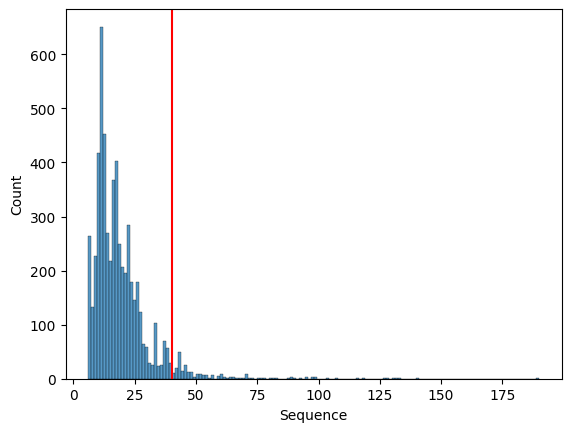

In [158]:
poslength = amp0.drop_duplicates(["DBAASP ID"])["Sequence"].apply(lambda x: len(x))
threshold = poslength.quantile(q=0.95)
sns.histplot(poslength)
plt.axvline(threshold, color='red')
print(f"MIN: {poslength.min()}; 95%QUANTILE: {threshold}; MAX: {poslength.max()}")

In [159]:
pos = amp0.iloc[np.where(amp0["Sequence"].apply(lambda x: len(x)) <= 40, True, False), :]
pos = pos[['Sequence', 'Target species', 'MIC (?g/mL )']]
pos.columns = ['Peptide', 'Target', 'MIC']
pos['Log2MIC'] = pos['MIC'].apply(lambda x: np.log2(x+1)).values
pos["Target"] = pos["Target"].apply(lambda x: x.replace(" ","_"))
pos = pos.replace("Salmonella_typhimurium", "Salmonella_enterica")
pos = pos.replace("Candida_krusei", "Pichia_kudriavzevii")
pos = pos.replace("Salmonella_enteritidis", "Salmonella_enterica")
pos = pos.replace("Candida_kefyr", "Kluyveromyces_marxianus")
pos = pos.replace("Xanthomonas_maltophilia", "Stenotrophomonas_maltophilia")
pos = pos.replace("Propionibacterium_acnes", "Cutibacterium_acnes")
pos = pos.replace("Bacillus_dysenteriae", "Shigella_dysenteriae")
pos = pos.replace("Erwinia_carotovora", "Pectobacterium_carotovorum")
pos = pos.replace("Bacillus_pyocyaneus", "Pseudomonas_aeruginosa")
pos = pos.replace("Streptococcus_lactis", "Lactococcus_lactis")
pos = pos.replace("Pseudomonas_maltophilia", "Stenotrophomonas_maltophilia")
pos = pos.replace("Pasteurella_trehalosi", "Bibersteinia_trehalosi")
pos = pos.replace("Micrococcus_lysodeikticus", "Micrococcus_luteus")
pos = pos.replace("Streptococcus_faecalis", "Enterococcus_faecalis")
pos = pos.replace("Bacillus_globigii", "Bacillus_subtilis")
pos = pos.replace("Rhizobium_meliloti", "Sinorhizobium_meliloti")
pos = pos.replace("Salmonella_newport", "Salmonella_enterica")
pos = pos.replace("Corynebacterium_insidiosum", "Clavibacter_michiganensis")
pos = pos.replace("Candida_glabrata", "Nakaseomyces_glabratus")
pos = pos.replace("Salmonella_pullorum", "Salmonella_enterica")
pos = pos.replace("Proteus_rettgeri", "Providencia_rettgeri")
pos = pos.replace("Salmonella_choleraesuis", "Salmonella_enterica")
pos = pos.replace("Salmonella_typhi", "Salmonella_enterica")
pos = pos.replace("Streptococcus_bovis", "Streptococcus_equinus")
pos = pos.replace("Salmonella_paratyphi", "Salmonella_enterica")
pos = pos.replace("Aeromonas_punctata", "Aeromonas_caviae")
pos = pos.replace("Pseudomonas_cepacia", "Burkholderia_cepacia")
pos = pos.replace("Salmonella_arizonae", "Salmonella_enterica")
pos = pos.replace("Candida_lusitaniae", "Clavispora_lusitaniae")
pos = pos.replace("Candida_utilis", "Cyberlindnera_jadinii")
pos = pos.replace("Pseudomonas_solanacearum", "Ralstonia_solanacearum")
pos = pos.replace("Enterobacter_amnigenus", "Lelliottia_amnigena")
pos = pos.replace("Streptococcus_sanguis", "Streptococcus_sanguinis")
pos = pos.replace("Salmonella_minnesota", "Salmonella_enterica")
pos = pos.replace("Brevibacterium_stationis", "Corynebacterium_stationis")
pos = pos.replace("Septoria_nodorum", "Parastagonospora_nodorum")
pos = pos.replace("Candida_guilliermondii", "Meyerozyma_guilliermondii")
pos = pos.replace("Salmonella_Paratyphi", "Salmonella_enterica")
pos = pos.replace("Candida_lipolytica", "Yarrowia_lipolytica")
pos = pos.replace("Fusarium_moniliforme", "Fusarium_verticillioides")
pos = pos.replace("Salmonella_anatum", "Salmonella_enterica")
# pos = pos.replace("Stemphylium", "Stemphylium_vesicarium")
# pos = pos.replace("Listonella_", "Listonella_anguillarum")
pos = pos.replace("Carnobacterium_piscicola", "Carnobacterium_maltaromaticum")
pos = pos.replace("Sarcina_lutea", "Micrococcus_luteus")
pos = pos.replace("Listeria_denitrificans", "Jonesia_denitrificans")
pos = pos.replace("Micrococcus_scarlatinae", "Streptococcus_pyogenes")
pos = pos.replace("Chryseobacterium_meningosepticum", "Elizabethkingia_meningoseptica")
pos = pos.replace("Klebsiella_ornithinolytica", "Raoultella_ornithinolytica")
pos = pos.replace("Micrococcus_nishinomiyaensis", "Dermacoccus_nishinomiyaensis")
pos = pos.replace("Actinobacillus_actinomycetemcomitans", "Aggregatibacter_actinomycetemcomitans")
pos = pos.replace("Streptococcus_equisimilis", "Streptococcus_dysgalactiae")
pos = pos.replace("Klebsiella_ozaenae", "Klebsiella_pneumoniae")
pos = pos.replace("Corynebacterium_michiganense", "Clavibacter_michiganensis")
pos = pos.replace("Peptostreptococcus_micros", "Parvimonas_micra")
pos = pos.replace("Cytophaga_drobachiensis", "Zobellia_galactanivorans")
pos = pos.replace("Pseudomonas_acidovorans", "Delftia_acidovorans")
pos = pos.replace("Bacillus_sphaericus", "Lysinibacillus_sphaericus")
pos = pos.replace("Haemophilus_Influenzae", "Haemophilus_influenzae")
pos = pos.replace("Haemophilus_ducreyi", "[Haemophilus]_ducreyi")

<Axes: xlabel='Log2MIC', ylabel='Count'>

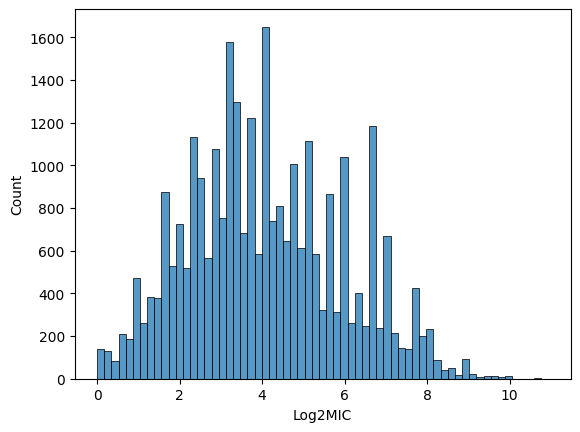

In [160]:
sns.histplot(pos["Log2MIC"])

In [162]:
marker_seqs = silva_seqs.copy(deep=True)
marker_seqs.columns = ["Marker", "lineage"]
marker_seqs["Species"] = marker_seqs["lineage"].apply(lambda x: x.split(" ")[-1])
marker_seqs = marker_seqs.drop_duplicates("Species")
marker_seqs = marker_seqs.drop(columns=["lineage"])
manual_collection = pp.ReadFASTA("drive/MyDrive/DreamWalker/source_data/manual_collection.fasta")
manual_collection = pd.DataFrame(manual_collection)
manual_collection["Species"] = manual_collection.index
manual_collection.columns=["Marker", "Species"]
marker_seqs = pd.concat([marker_seqs, manual_collection])

In [163]:
merged = pos.merge(marker_seqs, left_on="Target", right_on="Species", how="left").dropna()
merged = merged[["Peptide", "Target", "Marker", "Log2MIC"]]

In [166]:
PepTV = tf.keras.layers.TextVectorization(standardize=None, split="character",
                                          output_sequence_length=40,
                                          output_mode="int", name="PepTextVectorizer")

In [167]:
PepTV.adapt(pos["Peptide"])
enc_amp = PepTV(merged["Peptide"]).numpy()
PepVocal = np.array(PepTV.get_vocabulary())
print(PepVocal.shape)
np.save("drive/MyDrive/DreamWalker/model_weights/PepTV_vocal.npy", PepVocal)

(43,)


In [168]:
marker_amp_kmer = pp.CountKmers(merged["Marker"])

In [178]:
merged.to_csv("drive/MyDrive/DreamWalker/tidy_data/PeptideMarkerMIC.csv", index=False)
np.savez_compressed("drive/MyDrive/DreamWalker/tidy_data/target_whole", data=marker_amp_kmer)
np.savez_compressed("drive/MyDrive/DreamWalker/tidy_data/pep_whole", data=enc_amp)
np.savez_compressed("drive/MyDrive/DreamWalker/tidy_data/label_whole", data=merged["Log2MIC"])

## Split into Folds

In [173]:
kf = KFold(n_splits=4, shuffle=True, random_state=0)
_, (cv_index, test_index) = list(enumerate(kf.split(enc_amp)))[0]
pep_cv = enc_amp[cv_index]
target_cv = marker_amp_kmer[cv_index]
label_cv = merged["Log2MIC"].values[cv_index]
pep_test = enc_amp[test_index]
target_test = marker_amp_kmer[test_index]
label_test = merged["Log2MIC"].values[test_index]

In [177]:
np.savez_compressed("drive/MyDrive/DreamWalker/tidy_data/pep_test", data=pep_test)
np.savez_compressed("drive/MyDrive/DreamWalker/tidy_data/target_test", data=target_test)
np.savez_compressed("drive/MyDrive/DreamWalker/tidy_data/label_test", data=label_test)
np.savez_compressed("drive/MyDrive/DreamWalker/tidy_data/pep_cv", data=pep_cv)
np.savez_compressed("drive/MyDrive/DreamWalker/tidy_data/target_cv", data=target_cv)
np.savez_compressed("drive/MyDrive/DreamWalker/tidy_data/label_cv", data=label_cv)

In [175]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [181]:
for i, (train_index, val_index) in enumerate(kf.split(pep_cv)):
    pep_train = pep_cv[train_index]
    target_train = target_cv[train_index]
    label_train = label_cv[train_index]
    pep_val = pep_cv[val_index]
    target_val = target_cv[val_index]
    label_val = label_cv[val_index]
    np.savez_compressed(f"drive/MyDrive/DreamWalker/tidy_data/pep_train_{i}", data=pep_train)
    np.savez_compressed(f"drive/MyDrive/DreamWalker/tidy_data/target_train_{i}", data=target_train)
    np.savez_compressed(f"drive/MyDrive/DreamWalker/tidy_data/label_train_{i}", data=label_train)
    np.savez_compressed(f"drive/MyDrive/DreamWalker/tidy_data/pep_val_{i}", data=pep_val)
    np.savez_compressed(f"drive/MyDrive/DreamWalker/tidy_data/target_val_{i}", data=target_val)
    np.savez_compressed(f"drive/MyDrive/DreamWalker/tidy_data/label_val_{i}", data=label_val)

# Preprocess Peptides for Pre-training

In [ ]:
uniprot_seqs, uniprot_header = pp.ReadFASTA("drive/MyDrive/DreamWalker/source_data/uniref_length_6_TO_40_AND_identity_0_2024_01_10.fasta", as_pd=False)

<Axes: xlabel='Peptide', ylabel='Density'>

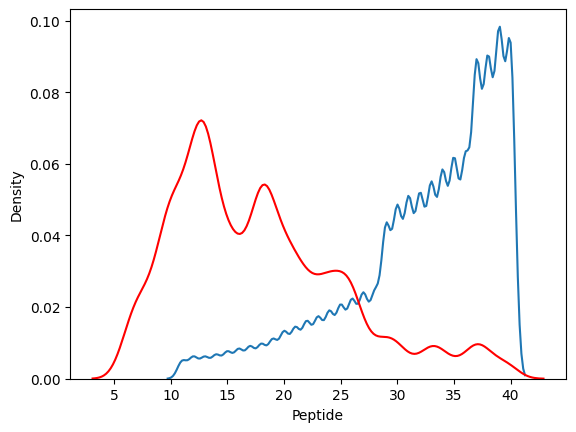

In [ ]:
uniprotlength = pd.Series(uniprot_seqs).apply(lambda x: len(x))
poslength = pos["Peptide"].apply(lambda x: len(x))
sns.kdeplot(uniprotlength)
sns.kdeplot(poslength, color="red")

In [ ]:
enc_uniprot = PepTV(uniprot_seqs).numpy()
np.savez_compressed("drive/MyDrive/DreamWalker/pre_train/Gen/enc_uniprot", data=enc_uniprot)